In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers, initializers
import random
import time
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
N = 1000

d = 10
P = 10
K = 2
mu = 0
sigma = 1
train_size = 800
m = 20

In [3]:
def generateAdj(N, p1, p2):
    adj_matrix = np.eye(N)
    for i in range(N-1):
        for j in range(N-i-1):
            if i < c:
                adj_matrix[i,i+j+1] = np.random.binomial(1,p1, 1);
            else:
                adj_matrix[i, i + j + 1] = np.random.binomial(1, p2, 1);
            adj_matrix[i+j+1,i] = adj_matrix[i,i+j+1];
    return adj_matrix

def l2_loss(logits, labels, mask):
    # use l_2 loss (regression loss)
    #loss = tf.losses.mean_squared_error (labels, logits)
    #loss = tf.nn.l2_loss(labels - logits)
    loss = tf.math.square(tf.norm(labels - logits, axis=1, ord=2))/2
    # taking mean over the number of traning data
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)
c=100
def generateAdj(N, p1, p2):
    adj_matrix = np.eye(N)
    for i in range(N-1):
        for j in range(N-i-1):
            if i < c:
                adj_matrix[i,i+j+1] = np.random.binomial(1,p1, 1)
            else:
                adj_matrix[i, i + j + 1] = np.random.binomial(1, p2, 1)
            adj_matrix[i+j+1,i] = adj_matrix[i,i+j+1]
    return adj_matrix

def generate_norm_adj_matrix(adj_matrix):
    adj_matrix = adj_matrix.astype('float32')
    deg_matrix = tf.reduce_sum(adj_matrix, axis=-1)
    deg_group = np.array([tf.reduce_mean(deg_matrix[0:tf.cast(c-1, tf.int32)]), tf.reduce_mean(deg_matrix[tf.cast(N-c, tf.int32): N-1])])
    norm_deg_matrix = tf.linalg.diag(1.0 / tf.sqrt(deg_matrix))
    norm_adj_matrix = tf.matmul(norm_deg_matrix, tf.matmul(adj_matrix, norm_deg_matrix))
    return norm_adj_matrix

adj_matrix = generateAdj(N, 0.4, 0.5)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)

In [4]:
def generateWeight(mu, sigma, d, P):
    # W d*P
    return np.random.normal(mu, sigma, (d, P))

def generateVeight(mu, sigma, K, P):
    # V d*P
    return np.random.normal(mu, sigma, (K, P))

def generateC(mu, sigma, P, K):
    # C P*K
    return np.random.normal(mu, sigma, (P, K))

def generateX(mu, sigma, N, d):
    return np.random.normal(mu, sigma, (N, d))

def generate_data(A_star, X, W, V, C, alpha):
    # A_star N*N, X N*d, W d*p, V K*p, C p*K,
    # node_labels = np.matmul(np.multiply(np.sin(tf.matmul(A_star, tf.matmul(X, W))),
    #                            np.tanh(tf.matmul(A_star, tf.matmul(X, W)))), C)
    # node_labels_F = np.matmul(np.sin(tf.matmul(A_star, tf.matmul(X, W))), C) # N*k
    # pow(tf.matmul(A_star, tf.matmul(node_labels_F, V)), 10)
    # # node_labels_G_F = np.matmul(np.sin(tf.matmul(A_star, tf.matmul(node_labels_F, V))), C) #N*k
    # node_labels_G_F = np.matmul(tf.matmul(A_star, tf.matmul(node_labels_F, V))**10, C) #N*k
    # node_labels_H = node_labels_F+ alpha * node_labels_G_F

    node_labels_F = np.matmul(tf.matmul(A_star, tf.matmul(X, W)), C) # N*k
    node_labels_G_F = np.matmul(np.multiply(np.sin(tf.matmul(A_star, tf.matmul(node_labels_F, V))),
                                               np.tanh(tf.matmul(A_star, tf.matmul(node_labels_F, V)))), C)
    node_labels_H = node_labels_F+ alpha * node_labels_G_F
    return node_labels_H

def createMask(index, N):
    mask = np.zeros(N)
    for i in index:
        mask[i] = 1
    return mask
batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)

In [6]:
learning_rate = 1e-4

optimizer = tf.optimizers.Adam(learning_rate)

def run_optimization(node_features, node_labels, train_mask, A_star, test_error):
    # Wrap computation inside a GradientTape for automatic differentiation.
    index_batch = set(random.sample(train_index, batch_size))
    train_mask = createMask(index_batch, N)
    # 产生batch数量相对应的mask矩阵
    with tf.GradientTape() as t:
        # Forward pass.
        logits = cora_gnn(node_features, A_star)
        # Compute loss.
        loss = l2_loss(logits, node_labels, train_mask) #train_mask

    # Variables to update, i.e. trainable variables.
    variables = t.watched_variables()

    # Compute gradients.
    gradients = t.gradient(loss, variables)

    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, variables))
    val_mse = l2_loss(logits, node_labels, val_mask)
    test_mse = l2_loss(logits, node_labels, test_mask)
    test_error.append(test_mse)
    if epoch % 500 == 0:
        print('Iteration', epoch, '| Training loss:', loss.numpy(), '| Val MSE:'
                      , val_mse.numpy(), '| Test MSE', test_mse.numpy())

In [71]:
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
val_size = int((N - train_size) / 2)
test_index.difference_update(train_index)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')

adj_matrix = generateAdj(N, 0.8, 0.1)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix

X = node_features
W = generateWeight(mu, sigma, d, P)
W = W.astype('float32')
C = generateC(mu, sigma, P, K)
C = C.astype('float32')
V = generateVeight(mu, sigma, K, P)
V = V.astype('float32')

In [72]:
alpha = 10
node_labels_A1 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)


2.0991855

In [88]:
node_labels_F = np.matmul(tf.matmul(A_star, tf.matmul(X, W)), C) # N*k
node_labels_G_F = np.matmul(np.multiply(np.sin(tf.matmul(A_star, tf.matmul(node_labels_F, V))),
                                               np.tanh(tf.matmul(A_star, tf.matmul(node_labels_F, V)))), C)
from numpy import linalg as LA
LA.norm(node_labels_F, 'fro')

25.981493

In [89]:
LA.norm(node_labels_G_F, 'fro')

6.8088336

In [ ]:
m = 20
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_20_A1 = []
learning_rate = 1

epochs = 50000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1, train_mask, A_star, test_error_20_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_20_A1), label='test_error_20_A1')

Iteration 0 | Training loss: 0.37715223 | Val MSE: 0.38778383 | Test MSE 0.3938538
Iteration 500 | Training loss: 0.4145704 | Val MSE: 0.38108644 | Test MSE 0.38915148


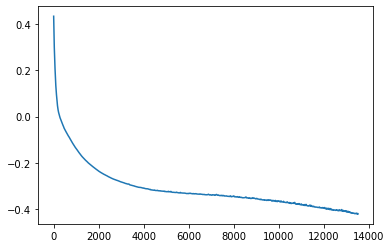

In [75]:
learning_rate = 5e-3
epochs = 1000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1, train_mask, A_star, test_error_20_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_20_A1), label='test_error_20_A1')

Iteration 0 | Training loss: 2.6837826 | Val MSE: 2.5957866 | Test MSE 2.4301226
Iteration 500 | Training loss: 0.36081937 | Val MSE: 0.6409378 | Test MSE 0.6248103
Iteration 1000 | Training loss: 0.4430808 | Val MSE: 0.54535806 | Test MSE 0.5453916
Iteration 1500 | Training loss: 0.47084624 | Val MSE: 0.4980306 | Test MSE 0.51408297
Iteration 2000 | Training loss: 0.59941417 | Val MSE: 0.47386453 | Test MSE 0.49670517
Iteration 2500 | Training loss: 0.45761365 | Val MSE: 0.4584149 | Test MSE 0.48184496
Iteration 3000 | Training loss: 0.46891627 | Val MSE: 0.44821984 | Test MSE 0.4713876
Iteration 3500 | Training loss: 0.40799415 | Val MSE: 0.44183472 | Test MSE 0.46258804
Iteration 4000 | Training loss: 0.3556942 | Val MSE: 0.4372909 | Test MSE 0.4546468
Iteration 4500 | Training loss: 0.29321453 | Val MSE: 0.43421498 | Test MSE 0.44866124


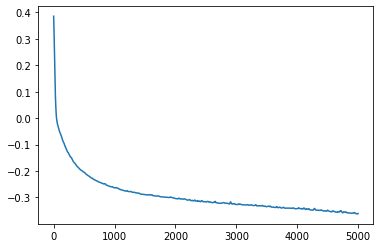

In [77]:
m = 50
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_50_A1 = []
learning_rate = 1
# alpha = 0.1
epochs = 5000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1, train_mask, A_star, test_error_50_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_50_A1), label='skip-connection')

Iteration 0 | Training loss: 0.6201522 | Val MSE: 0.4227876 | Test MSE 0.43584293
Iteration 500 | Training loss: 0.31072304 | Val MSE: 0.41280767 | Test MSE 0.4247181
Iteration 1000 | Training loss: 0.46328983 | Val MSE: 0.4038171 | Test MSE 0.41568562
Iteration 1500 | Training loss: 0.42165643 | Val MSE: 0.3945512 | Test MSE 0.40239796
Iteration 2000 | Training loss: 0.32354644 | Val MSE: 0.3839833 | Test MSE 0.3925688
Iteration 2500 | Training loss: 0.3984632 | Val MSE: 0.37441522 | Test MSE 0.38007075
Iteration 3000 | Training loss: 0.41696718 | Val MSE: 0.3650379 | Test MSE 0.36910066
Iteration 3500 | Training loss: 0.28477672 | Val MSE: 0.35029253 | Test MSE 0.35457438
Iteration 4000 | Training loss: 0.35349748 | Val MSE: 0.33827865 | Test MSE 0.33916938
Iteration 4500 | Training loss: 0.17748287 | Val MSE: 0.32788736 | Test MSE 0.32710674


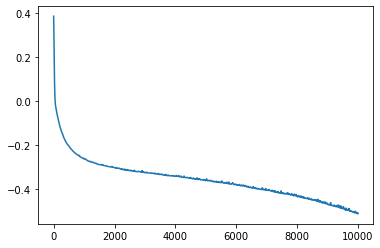

In [78]:
learning_rate = 1e-3
epochs = 5000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1, train_mask, A_star, test_error_50_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_50_A1), label='skip-connection')

Iteration 0 | Training loss: 1.8420112 | Val MSE: 2.7982786 | Test MSE 2.561646
Iteration 500 | Training loss: 0.3140695 | Val MSE: 0.5358024 | Test MSE 0.51027495
Iteration 1000 | Training loss: 0.28337047 | Val MSE: 0.47587413 | Test MSE 0.48153302
Iteration 1500 | Training loss: 0.27349597 | Val MSE: 0.45463777 | Test MSE 0.46949774
Iteration 2000 | Training loss: 0.41335112 | Val MSE: 0.43683544 | Test MSE 0.45311216
Iteration 2500 | Training loss: 0.38336542 | Val MSE: 0.41396996 | Test MSE 0.4305702
Iteration 3000 | Training loss: 0.36572278 | Val MSE: 0.39193806 | Test MSE 0.40572387
Iteration 3500 | Training loss: 0.44261417 | Val MSE: 0.36830524 | Test MSE 0.37773788
Iteration 4000 | Training loss: 0.2435813 | Val MSE: 0.3401916 | Test MSE 0.35008082
Iteration 4500 | Training loss: 0.181013 | Val MSE: 0.3098851 | Test MSE 0.31655523


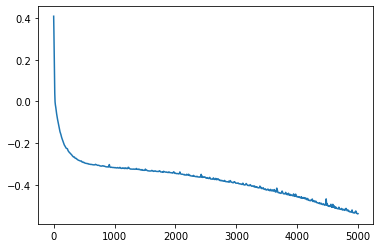

In [79]:
m = 100
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_100_A1 = []
learning_rate = 1
# alpha = 0.1
epochs = 5000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1, train_mask, A_star, test_error_100_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9

fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_100_A1), label='skip-connection')

Iteration 0 | Training loss: 0.18608038 | Val MSE: 0.285165 | Test MSE 0.29075652
Iteration 500 | Training loss: 0.19849096 | Val MSE: 0.2553921 | Test MSE 0.25798118
Iteration 1000 | Training loss: 0.16120082 | Val MSE: 0.22433499 | Test MSE 0.2292144
Iteration 1500 | Training loss: 0.11064173 | Val MSE: 0.20021886 | Test MSE 0.20084733
Iteration 2000 | Training loss: 0.2831889 | Val MSE: 0.17839077 | Test MSE 0.17768832
Iteration 2500 | Training loss: 0.09661463 | Val MSE: 0.15880404 | Test MSE 0.16081506
Iteration 3000 | Training loss: 0.111465275 | Val MSE: 0.14033014 | Test MSE 0.14327796
Iteration 3500 | Training loss: 0.08629326 | Val MSE: 0.1260284 | Test MSE 0.1287316
Iteration 4000 | Training loss: 0.05803802 | Val MSE: 0.11665311 | Test MSE 0.12046414
Iteration 4500 | Training loss: 0.08347376 | Val MSE: 0.1023714 | Test MSE 0.10731663


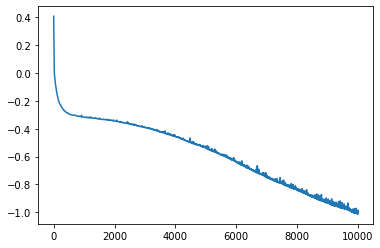

In [80]:
learning_rate = 1e-3
epochs = 5000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1, train_mask, A_star, test_error_100_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.5
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_100_A1), label='skip-connection')

Iteration 0 | Training loss: 3.2174788 | Val MSE: 3.2379775 | Test MSE 3.0804496
Iteration 500 | Training loss: 0.43675452 | Val MSE: 0.44549093 | Test MSE 0.47026834
Iteration 1000 | Training loss: 0.38148034 | Val MSE: 0.39654756 | Test MSE 0.41705582
Iteration 1500 | Training loss: 0.26811433 | Val MSE: 0.3464229 | Test MSE 0.3581786
Iteration 2000 | Training loss: 0.22718483 | Val MSE: 0.29694608 | Test MSE 0.3053528
Iteration 2500 | Training loss: 0.4674972 | Val MSE: 0.23694098 | Test MSE 0.24682431
Iteration 3000 | Training loss: 0.15816729 | Val MSE: 0.18916114 | Test MSE 0.20122838
Iteration 3500 | Training loss: 0.10921968 | Val MSE: 0.15401572 | Test MSE 0.1630553
Iteration 4000 | Training loss: 0.08747821 | Val MSE: 0.12545317 | Test MSE 0.13997549
Iteration 4500 | Training loss: 0.10575417 | Val MSE: 0.10785211 | Test MSE 0.12105007


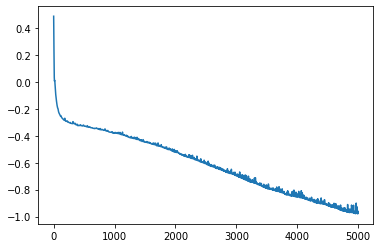

In [81]:
m = 250
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_250_A1 = []
learning_rate = 1e-1
# alpha = 0.1
epochs = 5000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1, train_mask, A_star, test_error_250_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_250_A1), label='skip-connection')

Iteration 0 | Training loss: 0.03933735 | Val MSE: 0.093834184 | Test MSE 0.106260434
Iteration 500 | Training loss: 0.11337619 | Val MSE: 0.08201871 | Test MSE 0.0947802
Iteration 1000 | Training loss: 0.06369398 | Val MSE: 0.07458764 | Test MSE 0.08974165
Iteration 1500 | Training loss: 0.068566054 | Val MSE: 0.06983869 | Test MSE 0.08265706
Iteration 2000 | Training loss: 0.052741054 | Val MSE: 0.06496261 | Test MSE 0.07827608
Iteration 2500 | Training loss: 0.030571744 | Val MSE: 0.057587676 | Test MSE 0.069581956
Iteration 3000 | Training loss: 0.025970586 | Val MSE: 0.053494833 | Test MSE 0.06637532
Iteration 3500 | Training loss: 0.022105213 | Val MSE: 0.05039937 | Test MSE 0.062347572
Iteration 4000 | Training loss: 0.05619381 | Val MSE: 0.0505599 | Test MSE 0.06265512
Iteration 4500 | Training loss: 0.03655462 | Val MSE: 0.047772612 | Test MSE 0.05925757


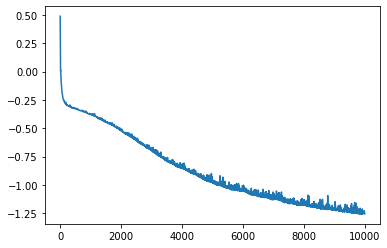

In [82]:
epochs = 5000
learning_rate = 1e-2
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1, train_mask, A_star, test_error_250_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.5
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_250_A1), label='skip-connection')

Iteration 0 | Training loss: 2.618126 | Val MSE: 2.5735943 | Test MSE 2.3276138
Iteration 500 | Training loss: 0.28953394 | Val MSE: 0.3470782 | Test MSE 0.3665783
Iteration 1000 | Training loss: 0.22374874 | Val MSE: 0.20190528 | Test MSE 0.21782485
Iteration 1500 | Training loss: 0.062852025 | Val MSE: 0.13671295 | Test MSE 0.14829576
Iteration 2000 | Training loss: 0.0842256 | Val MSE: 0.10165735 | Test MSE 0.116494395
Iteration 2500 | Training loss: 0.07946606 | Val MSE: 0.08626372 | Test MSE 0.10025802
Iteration 3000 | Training loss: 0.043224365 | Val MSE: 0.076274194 | Test MSE 0.089229524
Iteration 3500 | Training loss: 0.022343984 | Val MSE: 0.07016287 | Test MSE 0.08554131
Iteration 4000 | Training loss: 0.037198894 | Val MSE: 0.07695384 | Test MSE 0.093818694
Iteration 4500 | Training loss: 0.03635949 | Val MSE: 0.063786976 | Test MSE 0.07811127


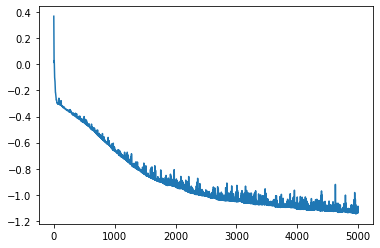

In [84]:
m = 500
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_500_A1 = []
learning_rate = 1

epochs = 5000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1, train_mask, A_star, test_error_500_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_500_A1), label='skip-connection')

Iteration 0 | Training loss: 0.036684096 | Val MSE: 0.058744688 | Test MSE 0.07308055
Iteration 500 | Training loss: 0.03197053 | Val MSE: 0.07063559 | Test MSE 0.08812879
Iteration 1000 | Training loss: 0.01694794 | Val MSE: 0.055544373 | Test MSE 0.06933059
Iteration 1500 | Training loss: 0.020357635 | Val MSE: 0.0530497 | Test MSE 0.064654484
Iteration 2000 | Training loss: 0.033036444 | Val MSE: 0.05126083 | Test MSE 0.06276403
Iteration 2500 | Training loss: 0.03691474 | Val MSE: 0.04869584 | Test MSE 0.060018823


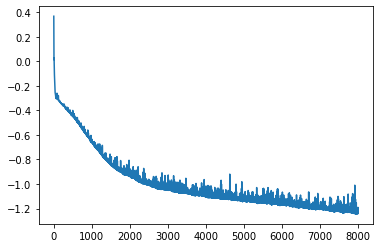

In [85]:
epochs = 3000
learning_rate = 1e-8
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1, train_mask, A_star, test_error_500_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.5
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_500_A1), label='skip-connection')

Iteration 0 | Training loss: 52.213318 | Val MSE: 42.12907 | Test MSE 36.447483
Iteration 500 | Training loss: 1.1129432 | Val MSE: 1.1837317 | Test MSE 1.37972
Iteration 1000 | Training loss: 0.3884525 | Val MSE: 0.334761 | Test MSE 0.42598912
Iteration 1500 | Training loss: 0.04150794 | Val MSE: 0.070267744 | Test MSE 0.09525076
Iteration 2000 | Training loss: 0.03577613 | Val MSE: 0.03783598 | Test MSE 0.05291068
Iteration 2500 | Training loss: 0.028000977 | Val MSE: 0.032131895 | Test MSE 0.043533213
Iteration 3000 | Training loss: 0.019188698 | Val MSE: 0.023608336 | Test MSE 0.034985863
Iteration 3500 | Training loss: 0.02048973 | Val MSE: 0.021089239 | Test MSE 0.03035962
Iteration 4000 | Training loss: 0.014358271 | Val MSE: 0.021355698 | Test MSE 0.028726453
Iteration 4500 | Training loss: 0.017879711 | Val MSE: 0.02568399 | Test MSE 0.03138486


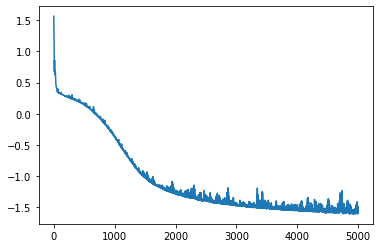

In [277]:
m = 1000
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_1000_A1 = []
learning_rate = 1
# alpha = 0.1

epochs = 5000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1, train_mask, A_star, test_error_1000_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1000_A1), label='skip-connection')

Iteration 0 | Training loss: 0.0006979632 | Val MSE: 0.0021214033 | Test MSE 0.0023699629
Iteration 500 | Training loss: 0.0006115952 | Val MSE: 0.001967999 | Test MSE 0.0020587863


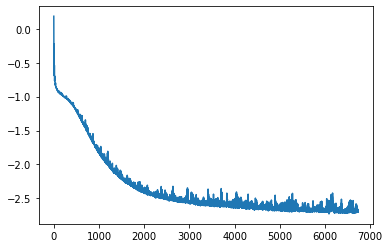

In [181]:
epochs = 1000
learning_rate = 1e-10
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1, train_mask, A_star, test_error_1000_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.5
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1000_A1), label='skip-connection')

In [51]:
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
val_size = int((N - train_size) / 2)
test_index.difference_update(train_index)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')

adj_matrix = generateAdj(N, 0.5, 0.4)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix

X = node_features
W = generateWeight(mu, sigma, d, P)
W = W.astype('float32')
C = generateC(mu, sigma, P, K)
C = C.astype('float32')
V = generateVeight(mu, sigma, K, P)
V = V.astype('float32')
node_labels_A2 = generate_data(A_star, X, W, V, C, alpha)

colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

1.143061

Iteration 0 | Training loss: 30.640118 | Val MSE: 31.052559 | Test MSE 30.896738
Iteration 500 | Training loss: 5.138058 | Val MSE: 5.034428 | Test MSE 4.885157
Iteration 1000 | Training loss: 0.41544273 | Val MSE: 0.5091988 | Test MSE 0.38907394
Iteration 1500 | Training loss: 0.21857533 | Val MSE: 0.31432506 | Test MSE 0.19315122
Iteration 2000 | Training loss: 0.26853952 | Val MSE: 0.3066874 | Test MSE 0.18686119
Iteration 2500 | Training loss: 0.27381194 | Val MSE: 0.29833955 | Test MSE 0.1824866
Iteration 3000 | Training loss: 0.17624366 | Val MSE: 0.27966565 | Test MSE 0.16971841
Iteration 3500 | Training loss: 0.23794459 | Val MSE: 0.26857892 | Test MSE 0.16115192
Iteration 4000 | Training loss: 0.32955784 | Val MSE: 0.25984347 | Test MSE 0.15416758
Iteration 4500 | Training loss: 0.25226185 | Val MSE: 0.25190866 | Test MSE 0.1479719


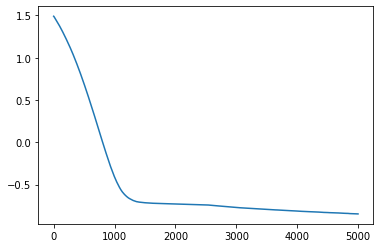

In [53]:
m = 20
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_20_A2 = []
learning_rate = 5e-1
# alpha = 0.2

epochs = 5000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A2, train_mask, A_star, test_error_20_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_20_A2), label='skip-connection')


Iteration 0 | Training loss: 0.21610643 | Val MSE: 0.24499196 | Test MSE 0.14251788
Iteration 500 | Training loss: 0.27603337 | Val MSE: 0.23892759 | Test MSE 0.13766836
Iteration 1000 | Training loss: 0.2710577 | Val MSE: 0.23447439 | Test MSE 0.13472092
Iteration 1500 | Training loss: 0.26303682 | Val MSE: 0.22853312 | Test MSE 0.13003677
Iteration 2000 | Training loss: 0.14670962 | Val MSE: 0.2228183 | Test MSE 0.1255751
Iteration 2500 | Training loss: 0.15407842 | Val MSE: 0.21781316 | Test MSE 0.122253634
Iteration 3000 | Training loss: 0.15926495 | Val MSE: 0.2136514 | Test MSE 0.119913325
Iteration 3500 | Training loss: 0.17570066 | Val MSE: 0.20937714 | Test MSE 0.11838337
Iteration 4000 | Training loss: 0.21453412 | Val MSE: 0.20464188 | Test MSE 0.11776943
Iteration 4500 | Training loss: 0.19313236 | Val MSE: 0.20153646 | Test MSE 0.11654452


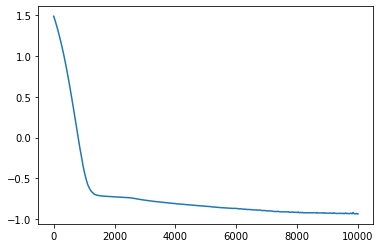

In [54]:
epochs = 5000
learning_rate = 1e-3
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A2, train_mask, A_star, test_error_20_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_20_A2), label='skip-connection')

Iteration 0 | Training loss: 30.248508 | Val MSE: 29.564407 | Test MSE 29.174046
Iteration 500 | Training loss: 0.3082046 | Val MSE: 0.31123096 | Test MSE 0.19129358
Iteration 1000 | Training loss: 0.222077 | Val MSE: 0.2846671 | Test MSE 0.17397684
Iteration 1500 | Training loss: 0.2451652 | Val MSE: 0.2655338 | Test MSE 0.16239175
Iteration 2000 | Training loss: 0.20050925 | Val MSE: 0.25173983 | Test MSE 0.15412532
Iteration 2500 | Training loss: 0.26616803 | Val MSE: 0.23965262 | Test MSE 0.14542234
Iteration 3000 | Training loss: 0.18036197 | Val MSE: 0.23039228 | Test MSE 0.13903467
Iteration 3500 | Training loss: 0.17427266 | Val MSE: 0.2234011 | Test MSE 0.13398989
Iteration 4000 | Training loss: 0.15805471 | Val MSE: 0.21663226 | Test MSE 0.12830028
Iteration 4500 | Training loss: 0.13320635 | Val MSE: 0.2115473 | Test MSE 0.12482056


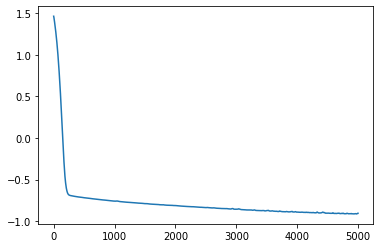

In [55]:
m = 50
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_50_A2 = []
learning_rate = 5e-1
# alpha = 0.1

epochs = 5000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A2, train_mask, A_star, test_error_50_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_50_A2), label='skip-connection')


Iteration 0 | Training loss: 0.14730544 | Val MSE: 0.20790508 | Test MSE 0.12414641
Iteration 500 | Training loss: 0.248243 | Val MSE: 0.20227624 | Test MSE 0.11937785
Iteration 1000 | Training loss: 0.15636553 | Val MSE: 0.19828275 | Test MSE 0.11688974
Iteration 1500 | Training loss: 0.16855694 | Val MSE: 0.1938304 | Test MSE 0.113101244
Iteration 2000 | Training loss: 0.18237604 | Val MSE: 0.1891786 | Test MSE 0.11075993
Iteration 2500 | Training loss: 0.113114394 | Val MSE: 0.18469921 | Test MSE 0.10736216


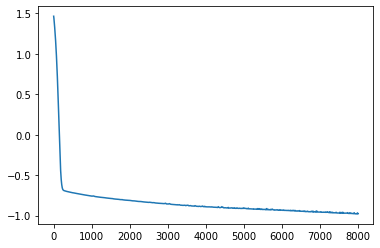

In [56]:
epochs = 3000
learning_rate = 1e-3
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A2, train_mask, A_star, test_error_50_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_50_A2), label='skip-connection')

Iteration 0 | Training loss: 29.814808 | Val MSE: 31.383402 | Test MSE 31.20725
Iteration 500 | Training loss: 0.2491495 | Val MSE: 0.28930405 | Test MSE 0.18713047
Iteration 1000 | Training loss: 0.22712058 | Val MSE: 0.25687253 | Test MSE 0.16000034
Iteration 1500 | Training loss: 0.14104427 | Val MSE: 0.23659433 | Test MSE 0.1439686
Iteration 2000 | Training loss: 0.19745557 | Val MSE: 0.22275253 | Test MSE 0.1336098
Iteration 2500 | Training loss: 0.18731876 | Val MSE: 0.21289551 | Test MSE 0.12783158
Iteration 3000 | Training loss: 0.21017955 | Val MSE: 0.2040798 | Test MSE 0.12112961
Iteration 3500 | Training loss: 0.1333293 | Val MSE: 0.19604617 | Test MSE 0.11792487
Iteration 4000 | Training loss: 0.21455884 | Val MSE: 0.18696794 | Test MSE 0.11056712
Iteration 4500 | Training loss: 0.10793436 | Val MSE: 0.18061247 | Test MSE 0.106121555


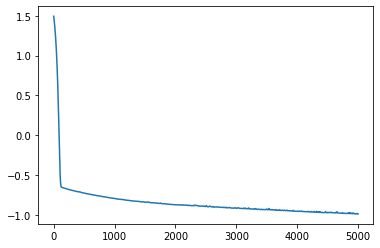

In [57]:
m = 100
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_100_A2 = []
learning_rate = 5e-1
# alpha = 0.1

epochs = 5000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A2, train_mask, A_star, test_error_100_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_100_A2), label='skip-connection')


Iteration 0 | Training loss: 0.05356341 | Val MSE: 0.07715266 | Test MSE 0.048058953
Iteration 500 | Training loss: 0.06153895 | Val MSE: 0.0686035 | Test MSE 0.04200666
Iteration 1000 | Training loss: 0.047262788 | Val MSE: 0.06201731 | Test MSE 0.037851784
Iteration 1500 | Training loss: 0.031903815 | Val MSE: 0.055428967 | Test MSE 0.034732696
Iteration 2000 | Training loss: 0.047885038 | Val MSE: 0.050679173 | Test MSE 0.03275133
Iteration 2500 | Training loss: 0.023262206 | Val MSE: 0.043948025 | Test MSE 0.02694939


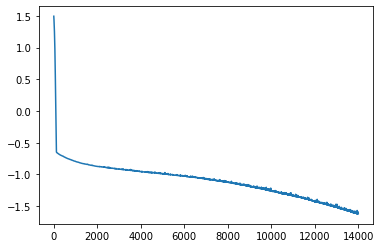

In [60]:
epochs = 3000
learning_rate = 1e-3
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A2, train_mask, A_star, test_error_100_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_100_A2), label='skip-connection')

Iteration 0 | Training loss: 30.946371 | Val MSE: 30.858524 | Test MSE 30.573002
Iteration 500 | Training loss: 0.21030499 | Val MSE: 0.22317193 | Test MSE 0.13233502
Iteration 1000 | Training loss: 0.112042 | Val MSE: 0.19947433 | Test MSE 0.11944972
Iteration 1500 | Training loss: 0.10725714 | Val MSE: 0.1878942 | Test MSE 0.115901306
Iteration 2000 | Training loss: 0.17369376 | Val MSE: 0.17217413 | Test MSE 0.1056156
Iteration 2500 | Training loss: 0.13687223 | Val MSE: 0.15940024 | Test MSE 0.09903458
Iteration 3000 | Training loss: 0.12634684 | Val MSE: 0.14916313 | Test MSE 0.095405504
Iteration 3500 | Training loss: 0.115472265 | Val MSE: 0.12771347 | Test MSE 0.07964753
Iteration 4000 | Training loss: 0.06792259 | Val MSE: 0.11122012 | Test MSE 0.0698141
Iteration 4500 | Training loss: 0.09350989 | Val MSE: 0.09514957 | Test MSE 0.06020566


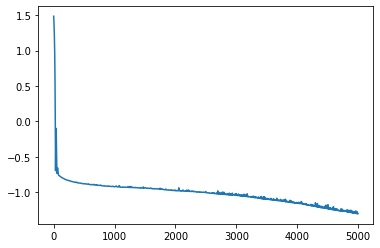

In [61]:
m = 250
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_250_A2 = []
learning_rate = 1
# alpha = 0.1

epochs = 5000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A2, train_mask, A_star, test_error_250_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_250_A2), label='skip-connection')


Iteration 0 | Training loss: 0.012423712 | Val MSE: 0.018327348 | Test MSE 0.013787203
Iteration 500 | Training loss: 0.012191958 | Val MSE: 0.013535979 | Test MSE 0.01081581
Iteration 1000 | Training loss: 0.0056710276 | Val MSE: 0.00992276 | Test MSE 0.008018543
Iteration 1500 | Training loss: 0.006113823 | Val MSE: 0.007629666 | Test MSE 0.0062490064
Iteration 2000 | Training loss: 0.004564096 | Val MSE: 0.005226421 | Test MSE 0.004654233
Iteration 2500 | Training loss: 0.0019004174 | Val MSE: 0.0037456837 | Test MSE 0.0034180407


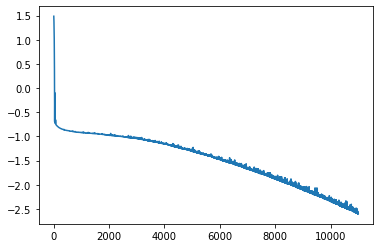

In [63]:
epochs = 3000
learning_rate = 1e-5
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A2, train_mask, A_star, test_error_250_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_250_A2), label='skip-connection')

Iteration 0 | Training loss: 31.943975 | Val MSE: 32.854576 | Test MSE 32.740356
Iteration 500 | Training loss: 0.14734106 | Val MSE: 0.20150927 | Test MSE 0.118835285
Iteration 1000 | Training loss: 0.16369845 | Val MSE: 0.18213733 | Test MSE 0.111734495
Iteration 1500 | Training loss: 0.11958434 | Val MSE: 0.1639698 | Test MSE 0.102040835
Iteration 2000 | Training loss: 0.14486395 | Val MSE: 0.1430711 | Test MSE 0.089237384
Iteration 2500 | Training loss: 0.107092716 | Val MSE: 0.1226808 | Test MSE 0.077533446


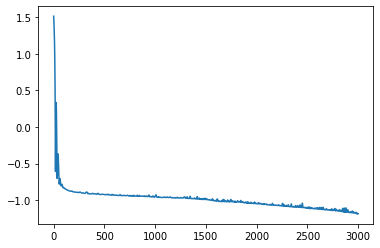

In [64]:
m = 500
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_500_A2 = []
learning_rate = 5e-1
# alpha = 0.1

epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A2, train_mask, A_star, test_error_500_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_500_A2), label='skip-connection')


Iteration 0 | Training loss: 0.0014114575 | Val MSE: 0.0034576936 | Test MSE 0.0027045263
Iteration 500 | Training loss: 0.0018922482 | Val MSE: 0.0032567992 | Test MSE 0.0033403768
Iteration 1000 | Training loss: 0.0007339431 | Val MSE: 0.0017655086 | Test MSE 0.0013224271
Iteration 1500 | Training loss: 0.0007022234 | Val MSE: 0.0014080863 | Test MSE 0.0012231714


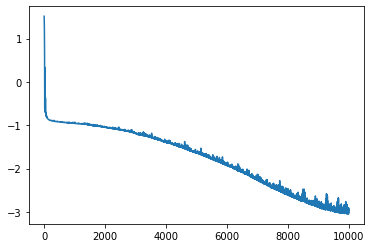

In [66]:
learning_rate = 5e-4
epochs = 2000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A2, train_mask, A_star, test_error_500_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_500_A2), label='skip-connection')


Iteration 0 | Training loss: 1.5104195 | Val MSE: 1.5477082 | Test MSE 1.4482874
Iteration 500 | Training loss: 0.067625046 | Val MSE: 0.07160777 | Test MSE 0.06396271
Iteration 1000 | Training loss: 0.01193895 | Val MSE: 0.01937486 | Test MSE 0.017652351
Iteration 1500 | Training loss: 0.0031346492 | Val MSE: 0.006032202 | Test MSE 0.0064867544
Iteration 2000 | Training loss: 0.0014545486 | Val MSE: 0.003589839 | Test MSE 0.0040513407
Iteration 2500 | Training loss: 0.0010756917 | Val MSE: 0.0027348008 | Test MSE 0.0030349405


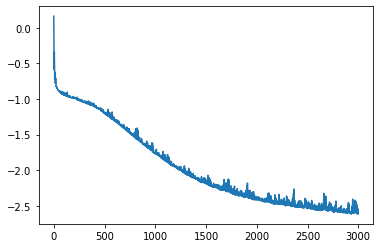

In [189]:
m = 1000
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_1000_A2 = []
learning_rate = 1
# alpha = 0.1

epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A2, train_mask, A_star, test_error_1000_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.5

fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1000_A2), label='skip-connection')


Iteration 0 | Training loss: 0.0004429483 | Val MSE: 0.0014177975 | Test MSE 0.0016574089
Iteration 500 | Training loss: 0.0001355191 | Val MSE: 0.0012625355 | Test MSE 0.0015300672


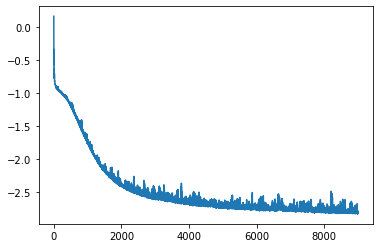

In [195]:
learning_rate = 1e-15
epochs = 1000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A2, train_mask, A_star, test_error_1000_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.5

fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1000_A2), label='skip-connection')

In [20]:
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
val_size = int((N - train_size) / 2)
test_index.difference_update(train_index)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')

adj_matrix = generateAdj(N, 0.8, 0.05)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix

X = node_features
W = generateWeight(mu, sigma, d, P)
W = W.astype('float32')
C = generateC(mu, sigma, P, K)
C = C.astype('float32')
V = generateVeight(mu, sigma, K, P)
V = V.astype('float32')
node_labels_A1_5 = generate_data(A_star, X, W, V, C, alpha)

colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

2.4249792

Iteration 0 | Training loss: 195.71541 | Val MSE: 211.4251 | Test MSE 202.35695
Iteration 500 | Training loss: 128.69653 | Val MSE: 137.43362 | Test MSE 133.32423
Iteration 1000 | Training loss: 63.072273 | Val MSE: 61.158863 | Test MSE 61.63278
Iteration 1500 | Training loss: 21.252304 | Val MSE: 21.623743 | Test MSE 22.671871
Iteration 2000 | Training loss: 11.230432 | Val MSE: 11.496369 | Test MSE 11.1605625
Iteration 2500 | Training loss: 8.754576 | Val MSE: 10.084143 | Test MSE 8.925945
Iteration 3000 | Training loss: 6.5228133 | Val MSE: 8.698887 | Test MSE 7.552574
Iteration 3500 | Training loss: 5.4673347 | Val MSE: 7.317848 | Test MSE 6.314072
Iteration 4000 | Training loss: 4.5642533 | Val MSE: 6.083511 | Test MSE 5.2192354
Iteration 4500 | Training loss: 4.09447 | Val MSE: 4.951868 | Test MSE 4.2695947
Iteration 5000 | Training loss: 2.9621866 | Val MSE: 4.064768 | Test MSE 3.5125027
Iteration 5500 | Training loss: 2.9557965 | Val MSE: 3.4194336 | Test MSE 2.968578
Iteration

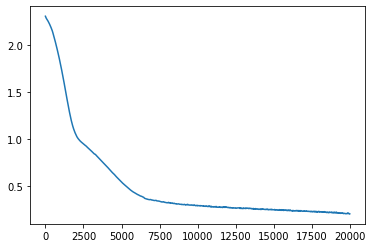

In [21]:
m = 20
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_20_A1_5 = []
learning_rate = 1e-1
# alpha = 0.1

epochs = 20000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1_5, train_mask, A_star, test_error_20_A1_5)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.5

fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_20_A1_5), label='skip-connection')

Iteration 0 | Training loss: 0.28110713 | Val MSE: 0.2338304 | Test MSE 0.25345218
Iteration 500 | Training loss: 0.21014884 | Val MSE: 0.22702445 | Test MSE 0.24901208
Iteration 1000 | Training loss: 0.25005794 | Val MSE: 0.2228739 | Test MSE 0.24618785
Iteration 1500 | Training loss: 0.2604944 | Val MSE: 0.21986166 | Test MSE 0.2454318


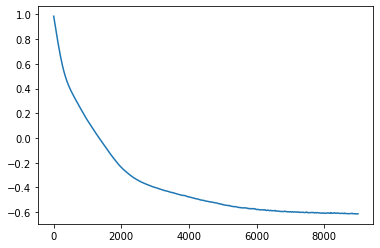

In [249]:
epochs = 2000
learning_rate = 1e-3
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1_5, train_mask, A_star, test_error_20_A1_5)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8

fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_20_A1_5), label='skip-connection')

Iteration 0 | Training loss: 182.30562 | Val MSE: 214.94441 | Test MSE 205.51785
Iteration 500 | Training loss: 26.86491 | Val MSE: 28.112705 | Test MSE 29.117374
Iteration 1000 | Training loss: 8.868735 | Val MSE: 11.968185 | Test MSE 10.501458
Iteration 1500 | Training loss: 7.795879 | Val MSE: 10.318807 | Test MSE 8.858705
Iteration 2000 | Training loss: 5.916868 | Val MSE: 8.432416 | Test MSE 7.271281
Iteration 2500 | Training loss: 4.7221437 | Val MSE: 6.648599 | Test MSE 5.7519054
Iteration 3000 | Training loss: 3.991598 | Val MSE: 5.1295457 | Test MSE 4.4868565
Iteration 3500 | Training loss: 2.5447407 | Val MSE: 4.010029 | Test MSE 3.4915268
Iteration 4000 | Training loss: 2.6961122 | Val MSE: 3.203299 | Test MSE 2.8222427
Iteration 4500 | Training loss: 2.882484 | Val MSE: 2.8095465 | Test MSE 2.4256914
Iteration 5000 | Training loss: 1.749267 | Val MSE: 2.5968833 | Test MSE 2.222572
Iteration 5500 | Training loss: 1.5907493 | Val MSE: 2.4483752 | Test MSE 2.1195674
Iteration 

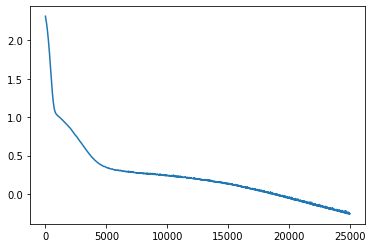

In [30]:
m = 50
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_50_A1_5 = []
learning_rate = 1
# alpha = 0.1

epochs = 25000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1_5, train_mask, A_star, test_error_50_A1_5)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
 
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_50_A1_5), label='skip-connection')

Iteration 0 | Training loss: 0.21614535 | Val MSE: 0.20305294 | Test MSE 0.22428454
Iteration 500 | Training loss: 0.13037017 | Val MSE: 0.19786356 | Test MSE 0.22007903
Iteration 1000 | Training loss: 0.14548282 | Val MSE: 0.19567962 | Test MSE 0.2173222
Iteration 1500 | Training loss: 0.16500473 | Val MSE: 0.1921449 | Test MSE 0.21425046


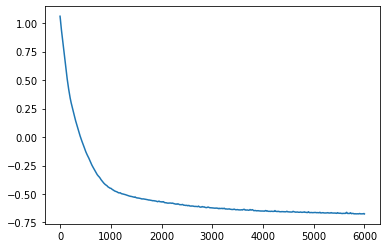

In [251]:
epochs = 2000
learning_rate = 1e-3
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1_5, train_mask, A_star, test_error_50_A1_5)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8

fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_50_A1_5), label='skip-connection')

Iteration 0 | Training loss: 180.16594 | Val MSE: 205.37181 | Test MSE 196.9165
Iteration 500 | Training loss: 3.9337475 | Val MSE: 9.049571 | Test MSE 7.8228083
Iteration 1000 | Training loss: 3.161598 | Val MSE: 4.706175 | Test MSE 4.168404
Iteration 1500 | Training loss: 1.9389596 | Val MSE: 2.9609845 | Test MSE 2.6110108
Iteration 2000 | Training loss: 1.9748895 | Val MSE: 2.5945425 | Test MSE 2.2747114
Iteration 2500 | Training loss: 1.9515395 | Val MSE: 2.4499433 | Test MSE 2.1552289
Iteration 3000 | Training loss: 1.6461641 | Val MSE: 2.3272412 | Test MSE 2.087167
Iteration 3500 | Training loss: 1.9268543 | Val MSE: 2.220131 | Test MSE 1.9864405
Iteration 4000 | Training loss: 2.0922506 | Val MSE: 2.119223 | Test MSE 1.9166778
Iteration 4500 | Training loss: 1.5320139 | Val MSE: 2.0134203 | Test MSE 1.8631936
Iteration 5000 | Training loss: 1.4961483 | Val MSE: 1.9284805 | Test MSE 1.7745183
Iteration 5500 | Training loss: 1.4236522 | Val MSE: 1.8736035 | Test MSE 1.6922551
Iter

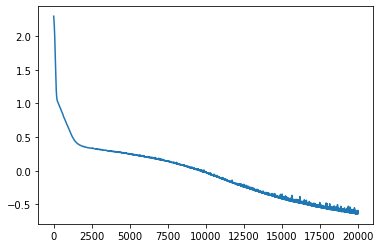

In [29]:
m = 100
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_100_A1_5 = []
learning_rate = 1e-1
# alpha = 0.1
epochs = 20000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1_5, train_mask, A_star, test_error_100_A1_5)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9

fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_100_A1_5), label='skip-connection')


Iteration 0 | Training loss: 0.051256455 | Val MSE: 0.05596193 | Test MSE 0.07309374
Iteration 500 | Training loss: 0.033317827 | Val MSE: 0.05139271 | Test MSE 0.07164613
Iteration 1000 | Training loss: 0.024143387 | Val MSE: 0.05266189 | Test MSE 0.072265275
Iteration 1500 | Training loss: 0.0810094 | Val MSE: 0.054905303 | Test MSE 0.07160913


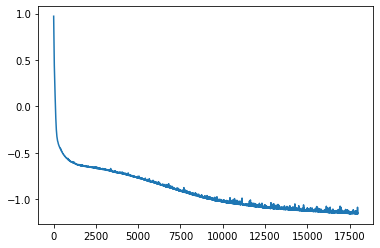

In [259]:
epochs = 2000
learning_rate = 1e-4

for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1_5, train_mask, A_star, test_error_100_A1_5)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8

fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_100_A1_5), label='skip-connection')

Iteration 0 | Training loss: 135.31277 | Val MSE: 201.06909 | Test MSE 193.5998
Iteration 500 | Training loss: 2.3498065 | Val MSE: 2.548375 | Test MSE 2.1958442
Iteration 1000 | Training loss: 1.5514627 | Val MSE: 2.2900052 | Test MSE 1.9890869
Iteration 1500 | Training loss: 1.5661843 | Val MSE: 2.1428673 | Test MSE 1.8444197
Iteration 2000 | Training loss: 1.5064664 | Val MSE: 1.9956919 | Test MSE 1.7246062
Iteration 2500 | Training loss: 1.6090971 | Val MSE: 1.8401783 | Test MSE 1.6187233
Iteration 3000 | Training loss: 1.6861018 | Val MSE: 1.6668916 | Test MSE 1.4797668
Iteration 3500 | Training loss: 1.3008426 | Val MSE: 1.5184189 | Test MSE 1.2726557
Iteration 4000 | Training loss: 0.73206073 | Val MSE: 1.3279119 | Test MSE 1.1045215
Iteration 4500 | Training loss: 1.0801827 | Val MSE: 1.1675906 | Test MSE 0.92702013
Iteration 5000 | Training loss: 0.48753694 | Val MSE: 1.0111598 | Test MSE 0.7965945
Iteration 5500 | Training loss: 0.45716456 | Val MSE: 0.89415514 | Test MSE 0.6

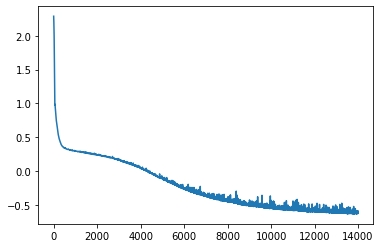

In [24]:
m = 250
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_250_A1_5 = []
learning_rate = 1
# alpha = 0.1

epochs = 14000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1_5, train_mask, A_star, test_error_250_A1_5)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9

fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_250_A1_5), label='skip-connection')

Iteration 0 | Training loss: 0.04389887 | Val MSE: 0.06939186 | Test MSE 0.08898971
Iteration 500 | Training loss: 0.06722542 | Val MSE: 0.06722068 | Test MSE 0.08495703
Iteration 1000 | Training loss: 0.109308 | Val MSE: 0.06576329 | Test MSE 0.0824668
Iteration 1500 | Training loss: 0.10946463 | Val MSE: 0.10645494 | Test MSE 0.11759533


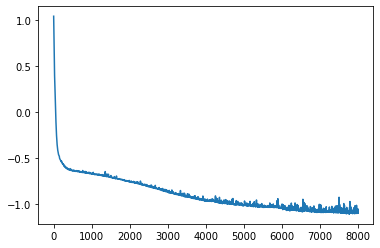

In [264]:
epochs = 2000

for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1_5, train_mask, A_star, test_error_250_A1_5)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8

fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_250_A1_5), label='skip-connection')

Iteration 0 | Training loss: 149.38469 | Val MSE: 206.06079 | Test MSE 198.15097
Iteration 500 | Training loss: 1.6363074 | Val MSE: 2.3347363 | Test MSE 2.0487206
Iteration 1000 | Training loss: 1.3868154 | Val MSE: 2.1406376 | Test MSE 1.8718896
Iteration 1500 | Training loss: 1.1205736 | Val MSE: 1.8782278 | Test MSE 1.6916301
Iteration 2000 | Training loss: 1.0800716 | Val MSE: 1.606236 | Test MSE 1.4467075
Iteration 2500 | Training loss: 1.047783 | Val MSE: 1.2621921 | Test MSE 1.067604
Iteration 3000 | Training loss: 0.77591383 | Val MSE: 0.9819809 | Test MSE 0.75506043
Iteration 3500 | Training loss: 0.55269724 | Val MSE: 0.7770989 | Test MSE 0.6207488
Iteration 4000 | Training loss: 0.64746046 | Val MSE: 0.7113171 | Test MSE 0.41917634
Iteration 4500 | Training loss: 0.30932438 | Val MSE: 0.62152857 | Test MSE 0.34804896
Iteration 5000 | Training loss: 0.33275366 | Val MSE: 0.74097496 | Test MSE 0.36482987
Iteration 5500 | Training loss: 0.16105506 | Val MSE: 0.5715853 | Test M

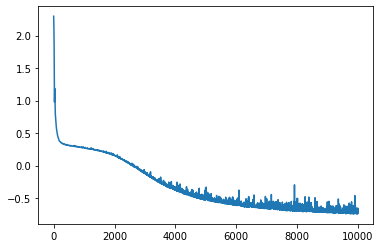

In [25]:
m = 500
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_500_A1_5 = []
learning_rate = 10
# alpha = 0.1

epochs = 10000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1_5, train_mask, A_star, test_error_500_A1_5)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_500_A1_5), label='skip-connection')

Iteration 0 | Training loss: 0.0013610878 | Val MSE: 0.003414068 | Test MSE 0.0031259798
Iteration 500 | Training loss: 0.0010167949 | Val MSE: 0.0026259823 | Test MSE 0.0024056053
Iteration 1000 | Training loss: 0.0008306278 | Val MSE: 0.00226531 | Test MSE 0.002020395
Iteration 1500 | Training loss: 0.000879186 | Val MSE: 0.0019855597 | Test MSE 0.0017431062
Iteration 2000 | Training loss: 0.0006803054 | Val MSE: 0.0018079989 | Test MSE 0.0014794738
Iteration 2500 | Training loss: 0.000383955 | Val MSE: 0.0015642497 | Test MSE 0.0013399374


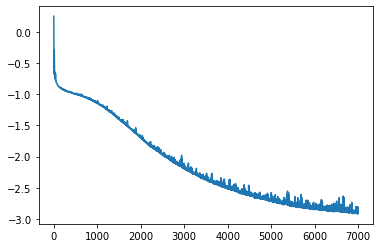

In [241]:
epochs = 3000
learning_rate = 1e-4
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1_5, train_mask, A_star, test_error_500_A1_5)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_500_A1_5), label='skip-connection')

Iteration 0 | Training loss: 11.583717 | Val MSE: 10.246588 | Test MSE 10.367198
Iteration 500 | Training loss: 0.1391683 | Val MSE: 0.15648493 | Test MSE 0.18763345
Iteration 1000 | Training loss: 0.09522975 | Val MSE: 0.10120788 | Test MSE 0.13099805
Iteration 1500 | Training loss: 0.10080917 | Val MSE: 0.08502223 | Test MSE 0.10473659
Iteration 2000 | Training loss: 0.08337595 | Val MSE: 0.0812102 | Test MSE 0.101402394
Iteration 2500 | Training loss: 0.084300615 | Val MSE: 0.075041324 | Test MSE 0.09512282
Iteration 3000 | Training loss: 0.058036093 | Val MSE: 0.07366999 | Test MSE 0.09311951
Iteration 3500 | Training loss: 0.085880294 | Val MSE: 0.06399971 | Test MSE 0.086780205


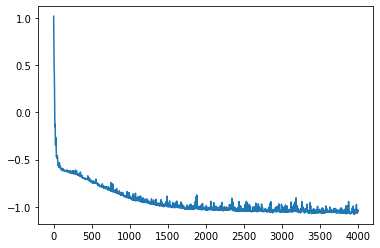

In [266]:
m = 1000
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

test_error_1000_A1_5 = []
learning_rate = 10

epochs = 4000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1_5, train_mask, A_star, test_error_1000_A1_5)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8

fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1000_A1_5), label='skip-connection')

In [ ]:
epochs = 4000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_A1_5, train_mask, A_star, test_error_1000_A1_5)

fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1000_A1_5), label='skip-connection')

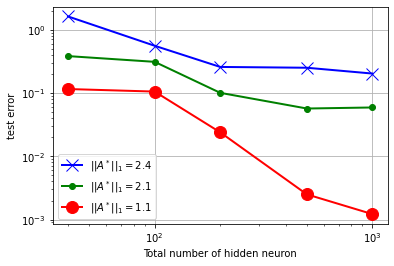

In [98]:
m=[20, 50, 100, 250, 500, 1000]
m1 = [40, 100, 200, 500, 1000]
if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
test_A1 = [np.mean(test_error_20_A1[-100:-1]),np.mean(test_error_50_A1[-100:-1]),test_error_100_A1[-1],np.mean(test_error_250_A1[-100:-1]),test_error_500_A1[-1]]
test_A2 = [test_error_20_A2[-1],test_error_50_A2[-1],test_error_100_A2[-1],np.mean(test_error_250_A2[-1]),test_error_500_A2[-1]]
test_A1_5 = [test_error_20_A1_5[-1],test_error_50_A1_5[-1],test_error_100_A1_5[-1],test_error_250_A1_5[-1],test_error_500_A1_5[-1]]
fig, ax = plt.subplots()
line3, = ax.plot(m1, test_A1_5, label=r'$||A^*||_1=2.4$',color='b', marker='x', markevery=1, linewidth=2, markersize=12)
line1, = ax.plot(m1, test_A1, label=r'$||A^*||_1=2.1$',color='g', marker='.', markevery=1, linewidth=2, markersize=12)
line2, = ax.plot(m1, test_A2, label=r'$||A^*||_1=1.1$',color='r', marker='o', markevery=1, linewidth=2, markersize=12)
ax.set(xlabel='Total number of hidden neuron', ylabel='test error')
ax.grid()
ax.legend()
plt.yscale('log')
plt.xscale('log')
plt.savefig('test error via iteration')
plt.show()


In [316]:
plt.plot(num_neurons, t1, color='g', marker='.', markevery=1,
     linewidth=2, markersize=12, label=r'$||A^*||_\infty=0.21$')

6

In [93]:
print(test_A1)

[0.38162768, 0.30975768, <tf.Tensor: shape=(), dtype=float32, numpy=0.10037263>, 0.056737255, <tf.Tensor: shape=(), dtype=float32, numpy=0.05894268>]


In [94]:
print(test_A2)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.11524167>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10504557>, <tf.Tensor: shape=(), dtype=float32, numpy=0.023876326>, 0.002502291, <tf.Tensor: shape=(), dtype=float32, numpy=0.0012202753>]


In [95]:
print(test_A1_5)

[<tf.Tensor: shape=(), dtype=float32, numpy=1.6136363>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5555338>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2572646>, <tf.Tensor: shape=(), dtype=float32, numpy=0.24987699>, <tf.Tensor: shape=(), dtype=float32, numpy=0.20228316>]


In [99]:
from tempfile import TemporaryFile
outfile = TemporaryFile()
np.save(outfile, test_A1)